In [269]:
import cartopy.crs as ccrs
import cartopy
import datetime as dt
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netCDF4
import numpy as np
import os

In [270]:
hofx_file = '/Users/afox/Jedi/Jedi_experiments/output/hofx/hofx3d_owp_snow_depth_2020030100_0000.nc'
datetime = '2020-03-01T00:00:00'
window_begin = '2020-02-29T12:00:00'
window_end = '2020-03-01T12:00:00'
metric = 'ObsValue' #'ObsValue'
field = 'snow_depth'
units = 'm'
output_path = './'
plotformat = 'png'

colmin = None
colmax = None

In [271]:
odat = []
lons = []
lats = []
time = []

# Message file being read
print(" Reading "+hofx_file)

# Open the file
fh = netCDF4.Dataset(hofx_file)

if metric=='omb':
    odat_proc = fh.groups['ObsValue'].variables[field][:] - fh.groups['hofx'].variables[field][:]
else:
    odat_proc = fh.groups[metric].variables[field][:]

# Read metadata
lons_proc = fh.groups['MetaData'].variables['longitude'][:]
lats_proc = fh.groups['MetaData'].variables['latitude'][:]
time_proc = fh.groups['MetaData'].variables['dateTime'][:]

for m in range(len(odat_proc)):
    odat.append(odat_proc[m])
    lons.append(lons_proc[m])
    lats.append(lats_proc[m])

fh.close()

 Reading /Users/afox/Jedi/Jedi_experiments/output/hofx/hofx3d_owp_snow_depth_2020030100_0000.nc


In [272]:
# Figure filename
# ---------------
field_savename = field

savename = os.path.join(output_path, field_savename+"_"+metric+"_"+datetime+"."+plotformat)

# Set missing values to nans
missing = 9.0e+30
odat = np.where(np.abs(odat) < missing, odat, float("NaN"))
   
numobs = len(odat)

obarray = np.empty([numobs, 3])

obarray[:, 0] = odat
obarray[:, 1] = lons
obarray[:, 2] = lats

obarray = obarray[obarray[:,2]<50.0]

In [273]:
# Compute and print some stats for the data
# -----------------------------------------
stdev = np.nanstd(obarray[:, 0])  # Standard deviation
omean = np.nanmean(obarray[:, 0]) # Mean of the data
datmi = np.nanmin(obarray[:, 0])  # Min of the data
datma = np.nanmax(obarray[:, 0])  # Max of the data

print("Plotted data statistics: ")
print("Mean: ", omean)
print("Standard deviation: ", stdev)
print("Minimum ", datmi)
print("Maximum: ", datma)

Plotted data statistics: 
Mean:  0.5416467882472166
Standard deviation:  0.8303115964799495
Minimum  0.0
Maximum:  6.883399963378906


In [274]:
# Norm for scatter plot
# ---------------------
norm = None


# Min max for colorbar
# --------------------
if np.nanmin(obarray[:, 0]) < 0:
    cmax = datma
    cmin = datmi
    cmap = 'RdBu'
else:
    cmax = omean+stdev
    cmin = np.maximum(omean-stdev, 0.0)
    cmap = 'viridis'

if metric == 'PreQC' or metric == 'EffectiveQC':
    cmin = datmi
    cmax = datma

# Specialized colorbar for integers
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[1] = (.5, .5, .5, 1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.insert(np.linspace(0.5, int(cmax)+0.5, int(cmax)+1), 0, 0)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# If using omb then use standard deviation for the cmin/cmax
if metric=='omb' or metric=='ombg' or metric=='oman':
    cmax = stdev
    cmin = -stdev

# Override with user chosen limits
if (colmin!=None):
    print("Using user provided minimum for colorbar")
    cmin = colmin
if (colmax!=None):
    print("Using user provided maximum for colorbar")
    cmax = colmax   

 Saving figure as ./snow_depth_ObsValue_2020-03-01T00:00:00.png 



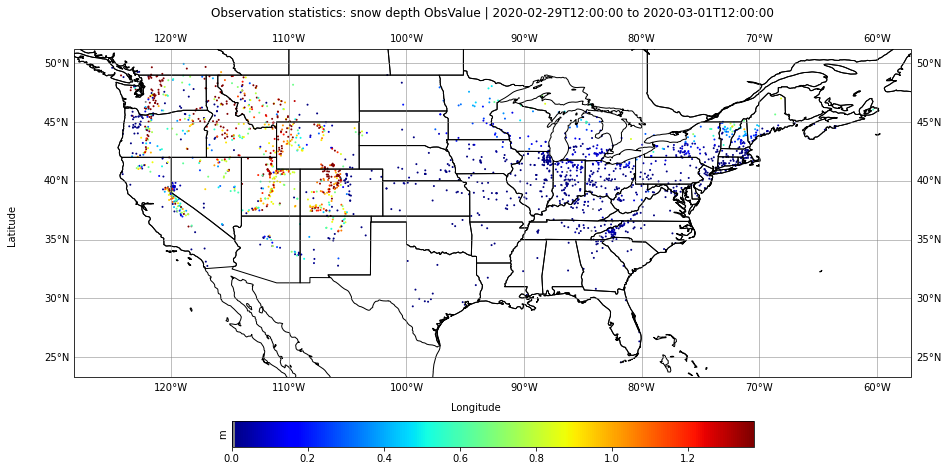

In [275]:
# Create figure
# -------------
fig = plt.figure(figsize=(15, 8))

# initialize the plot pointing to the projection
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# plot grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='-')

gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}
#gl.xlocator = mticker.FixedLocator(
#    [-180, -135, -90, -45, 0, 45, 90, 135, 179.9])
ax.set_ylabel("Latitude",  fontsize=7)
ax.set_xlabel("Longitude", fontsize=7)

ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)

# scatter data
sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=4, linewidth=0,
                transform=ccrs.PlateCarree(), cmap=cmap, vmin=cmin, vmax=cmax)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_ylabel(units, fontsize=10)

# plot globally
#ax.set_global()

# draw coastlines
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)

# figure labels
plt.title("Observation statistics: "+field.replace("_"," ")+" "+metric+" | "+
            window_begin+" to "+window_end, y=1.08)
ax.text(0.45, -0.1,   'Longitude', transform=ax.transAxes, ha='left')
ax.text(-0.08, 0.4, 'Latitude', transform=ax.transAxes,
        rotation='vertical', va='bottom')

# show plot
print(" Saving figure as", savename, "\n")
#plt.savefig(savename, facecolor='w', dpi = 400)

In [276]:
obarray = obarray[obarray[:,2]<41.0]
obarray = obarray[obarray[:,2]>37.0]
obarray = obarray[obarray[:,1]<-102.0]
obarray = obarray[obarray[:,1]>-109.4]
smallobs = obarray[:,0]<0.001
obarray[smallobs,0] = 0

 Saving figure as ./test.png 



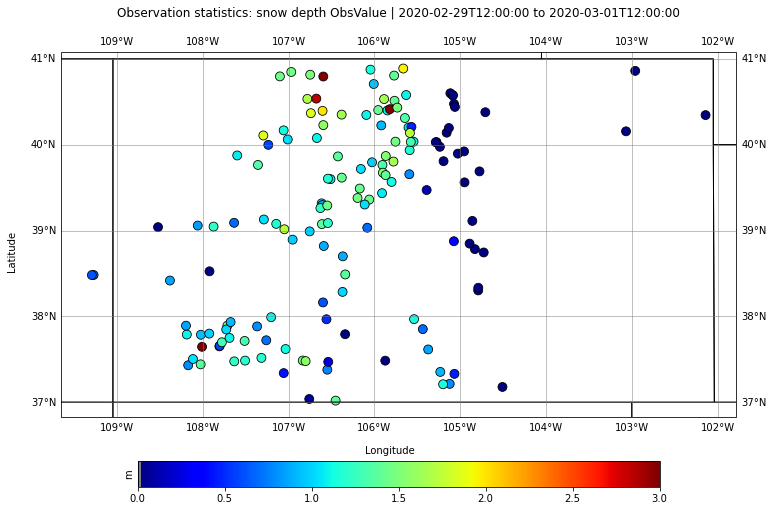

In [277]:
# Create figure
# -------------
fig = plt.figure(figsize=(15, 8))

# initialize the plot pointing to the projection
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# plot grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='-')

gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}
#gl.xlocator = mticker.FixedLocator(
#    [-180, -135, -90, -45, 0, 45, 90, 135, 179.9])
ax.set_ylabel("Latitude",  fontsize=7)
ax.set_xlabel("Longitude", fontsize=7)

ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)

# scatter data
sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=80, linewidth=0.8, edgecolors='black',
                transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=3)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_ylabel(units, fontsize=10)

# plot globally
#ax.set_global()

# draw coastlines
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)

# figure labels
plt.title("Observation statistics: "+field.replace("_"," ")+" "+metric+" | "+
            window_begin+" to "+window_end, y=1.08)
ax.text(0.45, -0.1,   'Longitude', transform=ax.transAxes, ha='left')
ax.text(-0.08, 0.4, 'Latitude', transform=ax.transAxes,
        rotation='vertical', va='bottom')

# show plot
savename = './test.png'
print(" Saving figure as", savename, "\n")
plt.savefig(savename, facecolor='w', dpi = 400)